In [1]:
import os
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

In [2]:
from ggmodel_dev.graphmodel import GraphModel, concatenate_graph_specs
from ggmodel_dev.validation import score_model, plot_diagnostic, score_model_dictionnary

from data_utils.database import select_dataset
from data_utils.utils import get_X_y_from_data, data_dict_from_df_tables

import pandas as pd
import numpy as np

# Data

In [3]:
def prepare_vehicle_data():

    df_tables = ['vehicleownership', 'vehicleownership_gompertz_param']
    
    df_dictionnary = {df_table: select_dataset(df_table) for df_table in df_tables}

    
    #df_dictionnary['vehicleownership'] = df_dictionnary['vehicleownership'].astype({'Year': int})
    
    data_dict = data_dict_from_df_tables([df_dictionnary['vehicleownership'][['ISO', 'Year', 'Variable', 'Value']]])
    
    data_dict.update(data_dict_from_df_tables([df_dictionnary['vehicleownership_gompertz_param'][['ISO', 'Variable', 'Value']]]))
    
    def process_series_0(series_name, series):
        s = series.reset_index(level='Year').dropna().astype({'Year': int}).set_index('Year', append=True)[series_name]
        return s
    
    def process_series_1(series_name, series):
        s = series.dropna().droplevel(level='Year')
        return s
    
    data_dict_0 = {k: process_series_0(k, v) for k, v in data_dict.items() if k not in ['MAX_sat', 'VEHC_mid', 'VEHC_rate']}
    data_dict_1 = {k:v  for k, v in data_dict.items() if k in ['MAX_sat', 'VEHC_mid', 'VEHC_rate']}

    data_dict = {}
    data_dict.update(data_dict_0)
    data_dict.update(data_dict_1)
    
    return data_dict

data_dict = prepare_vehicle_data()

# Model

In [4]:
graph_specifications = {
    'VEHC': {'type': 'output',
             'unit': 'vehicles per 1000 capita',
             'name': 'Vehicle ownership rate',
             'computation': lambda MAX_sat, VEHC_mid, VEHC_rate, GDPC, **kwargs:  MAX_sat * np.exp (-VEHC_mid * np.exp (-VEHC_rate * GDPC))
             },
    'MAX_sat': {'type': 'parameter', # Name to be changed ! 
              'unit': 'vehicles per 1000 capita',
              'name': 'max saturation level',
              },
    'VEHC_mid': {'type': 'parameter',
              'unit': '1',
              'name': 'Vehicle ownership halfway point'},

    'VEHC_rate': {'type': 'parameter',
             'unit': 'capita / constant 2010 US dollar',
             'name': 'Vehicle ownership growth rate'},

    'GDPC': {'type': 'input',
             'unit': 'constant 2010 US dollars per capita',
             'name': 'gross domestic product per capita'}
}

model = GraphModel(graph_specifications)

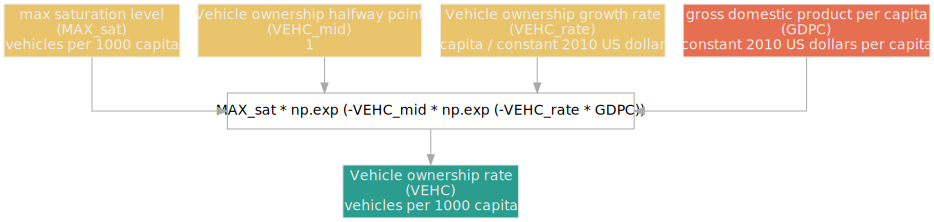

In [5]:
model.draw()

In [6]:
res = model.run(data_dict)

In [7]:
scores = score_model(model, data_dict)

/home/simon/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/simon/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/simon/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/simon/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/simon/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/simon/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2480: Runti

In [8]:
scores.keys()

dict_keys(['score_by_Variable', 'score_by_ISO', 'score_by_ISO_Variable'])

In [9]:
scores['score_by_ISO']

,r2,correlation,rmse
ISO,,,
AFG,0.448653,0.911847,26.945550
AGO,0.512870,0.938691,10.737179
ALB,0.532821,0.986402,1072.192207
AND,-0.168029,-0.293398,18936.984066
ARE,-4.326114,-0.157247,1776.186568
...,...,...,...
VNM,-0.051499,0.958054,29.432298
YEM,-0.490195,-0.785229,3.550747
ZAF,0.815570,0.904536,5.241889


In [10]:
scores['score_by_Variable']

,r2,correlation,rmse
Variable,,,
VEHC,0.93657,0.96985,2656.237922
